# Project 5: Vehicle Detection

The project aims to develop an algorithm to detect cars in a video stream. Clearly, this is an important requirement for a self driving car in order to avoid collisions with other cars. A real self driving car has also to be able to detect other objects reliably (e.g. pedestrians, bicycles). However, this project focuses on cars only.

First, one has to train a classifier which is able to distinguish between cars and background. Udacity provided a large labeled data set to do so. Next, one has to divide the original image in a set of subimages using the sliding window technique. Each subimage is is feed to a classifier. In a last step the positive detections are combined and bounding boxes for detected cars are drawn on the image. In the following each step is discussed in detail.

## 1. Load and explore data

In the beginning let's have a quick look at the training data provided by Udacity. This training data has 17584 instances. 8792 are images of cars and 8792 are images of non-cars. The car images are taken (see next images) under different angles and perspectives of various cars. The non-car images display typical background structures found in the surroundings of a street, e.g. lane lines or the lane itself.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

%matplotlib inline  


def display_images(images, figsize = (15, 10), title=None, fontsize=20, ncols=5):
    "Display images in ncols columns. Choose gray-scale colorbar if image is two-dimensional."
    nrows = np.ceil(len(images)/ncols)
    
    fig = plt.figure(figsize = figsize)
    for i, image in enumerate(images, start = 1):
        ax = fig.add_subplot(nrows, ncols, i)
        if title is not None:
            ax.set_title(title[i-1], fontsize=fontsize)
        plt.imshow(image) if len(image.shape) == 3 else plt.imshow(image, cmap='gray')
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()


# read images and scale them to range 0 to 255
vehicles = [(mpimg.imread(image)*255).astype(np.uint8) for image in glob.glob("./vehicles/*/*.png")]
non_vehicles = [(mpimg.imread(image)*255).astype(np.uint8) for image in glob.glob("./non-vehicles/*/*.png")]

In [2]:
print('vehicle:    ', len(vehicles))
print('non-vehicle:', len(vehicles))

vehicle:     8792
non-vehicle: 8792


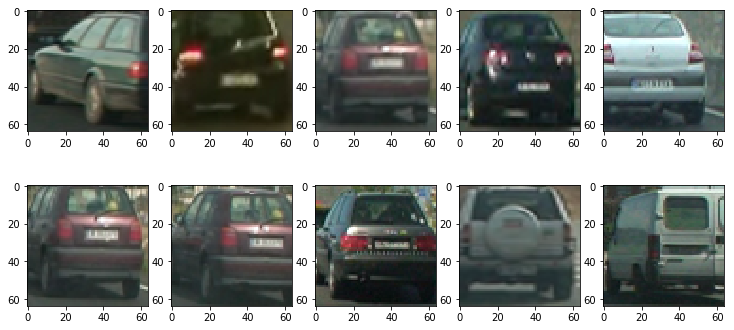

In [3]:
display_images(vehicles[:10], figsize=(10, 5))

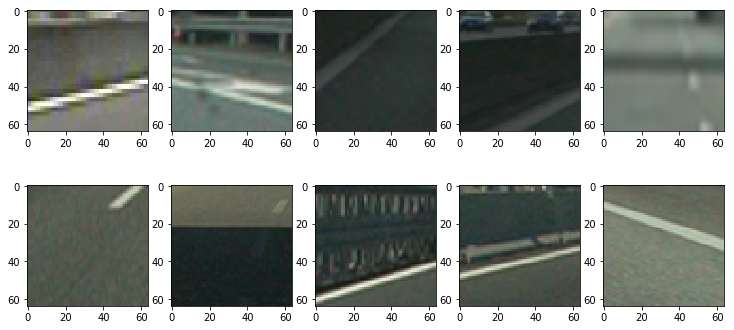

In [4]:
display_images(non_vehicles[:10], figsize=(10, 5))

## 2. Classifier

We make use of labeled data set to train a support vector machine but first we have to decide on the input features. We use three different feature types
* binned raw pixel values
* color histogram
* hog features.

One feature type are binned raw pixels values. We take the flattened raw pixel values as input features and resize slightly the original figure from 64x64 pixels to 32x32 pixels. Another feature are color histograms. We simply fill the values of each color channel in a histogram and take the histogram values as input features (any spatial information is lost). The last feature type are HOG features (histogram of oriented gradients). Gradients in general are a good indicator for the shape of an object. However pure gradient values are sensitive to small variations in shape. HOG features are in excellent method to reduce this sensitivity. The basic idea is to divide an image in a number of cells, each containing a couple of pixels. The gradient direction of each pixel is multiplied with its magnitude. All these vectors are filled in a histogram. Afterward the average of the histogram values are taken. The resulting vector of each cell is robust to small variations in shape while still giving enough information about the object shape for a classifier.

We've choosen orient=9 (histogram bins), pix_per_cell=8 (pixels pers cell), cell_per_block=2 as parameters. cells_per_block gives the number of cells over which the histogram bins are normalized. This is not requiered but leads to more robust features. The resolution of orient=9 is good enough for our purpose while limiting the total number of features. The choice of pix_per_cell=8 is a trade-off between creating a robust feature and still providing enough information on the object shape.

A transformation to another color space is also good method to improve the quality of the features.

In [5]:
from skimage.feature import hog


def bin_spatial(img, size=(32, 32)):
    """Resize img to size and unroll pixels.
    
    Allows to use raw pixels as features.
    
    Args:
        img  -- input image
        size -- desired dimensions of output image
    """
    return cv2.resize(img, size).ravel()


def color_hist(img, nbins=32, bins_range=(0, 256)):
    """Return histogram values for each color channel.
    
    Args:
        img       -- input image (three channels)
        nbins     -- bin number
        bin_range -- max and min value of histogram
    """
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # concatenate bin-values of all channels (flat array of size 3*nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


def convert_color(img, conv='RGB2YUV'):
    """Convert RGB image to another color space.
    
    Options for conv:
        - RGB2YCrCb
        - RGB2LUV
        - RGB2HLS
        - RGB2HSVget_hog_features
        - RGB2YUV
    """
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv =='RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    raise ValueError('Unkown colorspace transformation: {}'.format(conv))
     
    
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=2, feature_vector=True):
    """Return hog features.
    
    Args:
         img            -- original channel (three channels)
         orient         -- orientation
         pixel_per_cell -- pixels per cell
         cell_per_block -- cells per block
         hog_channel    -- hog channel (allowed values 0, 1, 2, 3, ALL)
    """
    assert hog_channel in (0, 1, 2, 'ALL')
    if hog_channel == 'ALL':
        hog_features = []
        for chan in range(img.shape[2]):
            features = hog(img[:, :, chan], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                           cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',transform_sqrt=True, 
                           visualise=False, feature_vector=feature_vector)
            hog_features.append(features)
            return np.ravel(hog_features)    
    return hog(img[:, :, hog_channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
               cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',transform_sqrt=True, 
               visualise=False, feature_vector=feature_vector)


def extract_features(image, conv='RGB2YUV', size=(32, 32), nbins=32, bins_range=(0, 256), 
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    """Return spatial color, hist and hog features.
    
    Args:
         image          -- original channel (three channels and RGB color space)
         conv           -- color space trafo (None, RGB2YCrCb, RGB2LUV, RGB2HLS, RGB2HSV, RGB2YUV) 
         size           -- binning of spatial color feature
         nbins          -- binning of histogram
         bins_range     -- range of histogram
         orient         -- orientation
         pixel_per_cell -- pixels per cell
         cell_per_block -- cells per block
         hog_channel    -- hog channel (allowed values 0, 1, 2, ALL)    
    """    
    img = np.copy(image)
    if conv is not None:
        img = convert_color(img, conv)
    spatial_features = bin_spatial(img, size)
    hist_features = color_hist(img, nbins, bins_range)
    hog_features = get_hog_features(image, orient, pix_per_cell, cell_per_block, hog_channel)   
    return np.concatenate((spatial_features, hist_features, hog_features))

The function *extract_features* is a wrapper for all three functions (which return one feature type) and returns one large, flattened feature vector. We extract the features of each image of the training set and feed these features to the SVM classifier. Beforehand we have to normalize the features using the StandardScaler module of sklearn which zero-centers and scales the data set.

In [6]:
vehicles_feature = [extract_features(image) for image in vehicles]
non_vehicles_feature = [extract_features(image) for image in non_vehicles]

# 0: no car
# 1: car
X = np.vstack((vehicles_feature, non_vehicles_feature)).astype(np.float64)
y = np.hstack((np.ones(len(vehicles_feature)), np.zeros(len(non_vehicles_feature))))

# fit model (example)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_scaler = StandardScaler().fit(X_train)
svc = LinearSVC(C=0.001)
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.973536036036036

The performance of the model can be assesed with a validation set. The model itself has a couple of parameters we can tune. We limit our tuning effort to three color space transformations, three different values for the parameter $C$ (penalty parameter for the error term), two different values for the number of bins for the color histogram feature and four different values for the number of used channels for extracting HOG features. In total we try 3x3x2x4=72 parameter combinations and validate each model on a validation set (20% of the training set). The results are summarized in the following table.

In [ ]:
for conv in (None, 'RGB2YCrCb', 'RGB2HSV'):
    for C in (0.001, 0.003, 0.01):
        for nbins in (16, 32):
            for hog_channel in (0, 1, 2, 'ALL'):
                vehicles_feature = [extract_features(image, conv=conv, nbins=nbins, hog_channel=hog_channel) 
                                    for image in vehicles
                non_vehicles_feature = [extract_features(image, conv=conv, nbins=nbins, hog_channel=hog_channel) 
                                        for image in non_vehicles]

                X = np.vstack((vehicles_feature, non_vehicles_feature)).astype(np.float64)
                y = np.hstack((np.ones(len(vehicles_feature)), np.zeros(len(non_vehicles_feature))))
                
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
                X_scaler = StandardScaler().fit(X_train)
                X_train = X_scaler.transform(X_train)
                X_test = X_scaler.transform(X_test)
                
                svc = LinearSVC(C=C)
                svc.fit(X_train, y_train)
                accuracy = svc.score(X_test, y_test)
                
                print("conv: {:<9}    C: {:<5}    nbins: {:<5}    hog_channel: {:<5}    accuracy: {:<5}".format(
                    str(conv), C, nbins, hog_channel, accuracy))
                

id |conv | C | nbins | hog_channel | accuracy
------|------|------|------|------|------
1 | None | 0.001 | 16 | 0 | 0.977
2 | None | 0.001 | 16 | 1 | 0.979
3 | None | 0.001 | 16 | 2 | 0.977
4 | None | 0.001 | 16 | ALL | 0.976
5 | None | 0.001 | 32 | 0 | 0.983
6 | None | 0.001 | 32 | 1 | 0.985
7 | None | 0.001 | 32 | 2 | 0.981
8 | None | 0.001 | 32 | ALL | 0.984
9 | None | 0.003 | 16 | 0 | 0.981
10 | None | 0.003 | 16 | 1 | 0.981
11 | None | 0.003 | 16 | 2 | 0.98
12 | None | 0.003 | 16 | ALL | 0.979
13 | None | 0.003 | 32 | 0 | 0.985
14 | None | 0.003 | 32 | 1 | 0.986
15 | None | 0.003 | 32 | 2 | 0.979
16 | None | 0.003 | 32 | ALL | 0.983
17 | None | 0.01 | 16 | 0 | 0.974
18 | None | 0.01 | 16 | 1 | 0.977
19 | None | 0.01 | 16 | 2 | 0.977
20 | None | 0.01 | 16 | ALL | 0.978
21 | None | 0.01 | 32 | 0 | 0.98
22 | None | 0.01 | 32 | 1 | 0.98
23 | None | 0.01 | 32 | 2 | 0.982
24 | None | 0.01 | 32 | ALL | 0.977
25 | RGB2YCrCb | 0.001 | 16 | 0 | 0.981
26 | RGB2YCrCb | 0.001 | 16 | 1 | 0.979
27 | RGB2YCrCb | 0.001 | 16 | 2 | 0.982
28 | RGB2YCrCb | 0.001 | 16 | ALL | 0.98
29 | RGB2YCrCb | 0.001 | 32 | 0 | 0.981
30 | RGB2YCrCb | 0.001 | 32 | 1 | 0.986
31 | RGB2YCrCb | 0.001 | 32 | 2 | 0.984
32 | RGB2YCrCb | 0.001 | 32 | ALL | 0.985
33 | RGB2YCrCb | 0.003 | 16 | 0 | 0.98
34 | RGB2YCrCb | 0.003 | 16 | 1 | 0.982
35 | RGB2YCrCb | 0.003 | 16 | 2 | 0.977
36 | RGB2YCrCb | 0.003 | 16 | ALL | 0.977
37 | RGB2YCrCb | 0.003 | 32 | 0 | 0.983
38 | RGB2YCrCb | 0.003 | 32 | 1 | 0.985
39 | RGB2YCrCb | 0.003 | 32 | 2 | 0.982
40 | RGB2YCrCb | 0.003 | 32 | ALL | 0.982
41 | RGB2YCrCb | 0.01 | 16 | 0 | 0.975
42 | RGB2YCrCb | 0.01 | 16 | 1 | 0.977
43 | RGB2YCrCb | 0.01 | 16 | 2 | 0.977
44 | RGB2YCrCb | 0.01 | 16 | ALL | 0.98
45 | RGB2YCrCb | 0.01 | 32 | 0 | 0.979
46 | RGB2YCrCb | 0.01 | 32 | 1 | 0.988
47 | RGB2YCrCb | 0.01 | 32 | 2 | 0.982
48 | RGB2YCrCb | 0.01 | 32 | ALL | 0.982
49 | RGB2HSV | 0.001 | 16 | 0 | 0.984
50 | RGB2HSV | 0.001 | 16 | 1 | 0.982
51 | RGB2HSV | 0.001 | 16 | 2 | 0.987
52 | RGB2HSV | 0.001 | 16 | ALL | 0.982
53 | RGB2HSV | 0.001 | 32 | 0 | 0.981
__54__ | __RGB2HSV__ | __0.001__ | __32__ | __1__ | __0.988__
55 | RGB2HSV | 0.001 | 32 | 2 | 0.986
56 | RGB2HSV | 0.001 | 32 | ALL | 0.986
57 | RGB2HSV | 0.003 | 16 | 0 | 0.983
58 | RGB2HSV | 0.003 | 16 | 1 | 0.984
59 | RGB2HSV | 0.003 | 16 | 2 | 0.983
60 | RGB2HSV | 0.003 | 16 | ALL | 0.983
61 | RGB2HSV | 0.003 | 32 | 0 | 0.979
62 | RGB2HSV | 0.003 | 32 | 1 | 0.984
63 | RGB2HSV | 0.003 | 32 | 2 | 0.987
64 | RGB2HSV | 0.003 | 32 | ALL | 0.986
65 | RGB2HSV | 0.01 | 16 | 0 | 0.98
66 | RGB2HSV | 0.01 | 16 | 1 | 0.978
67 | RGB2HSV | 0.01 | 16 | 2 | 0.982
68 | RGB2HSV | 0.01 | 16 | ALL | 0.985
69 | RGB2HSV | 0.01 | 32 | 0 | 0.985
70 | RGB2HSV | 0.01 | 32 | 1 | 0.986
71 | RGB2HSV | 0.01 | 32 | 2 | 0.984
72 | RGB2HSV | 0.01 | 32 | ALL | 0.981
 

We intended to use the model with the best performance on the validation set (conv=RGB2HSV, C=0.001, nbins=32, hog_channel=1). In general the differences of the models in terms of performance on the validation sets are small. Surprisingly, the choosen model does to perform well on the actual video and test images of this project. A much better choice is the parameter set: conv='RGB2YUV', C=0.001, nbins=32, hog_channel='ALL', although its performance on the validation set amounts to 97.5% only. One reason might be that the video stream is qualitatively different from the images of data set provided by Udacity. One way to resolve this issue would be to enrich the original data set with images taken from the video stream (which would be very time consuming). 

We train the model on the full data set. 

In [7]:
vehicles_feature = [extract_features(image) for image in vehicles]
non_vehicles_feature = [extract_features(image) for image in non_vehicles]
X = np.vstack((vehicles_feature, non_vehicles_feature)).astype(np.float64)
y = np.hstack((np.ones(len(vehicles_feature)), np.zeros(len(non_vehicles_feature))))

X_scaler = StandardScaler().fit(X)
X_train = X_scaler.transform(X)

svc = LinearSVC(C=0.001)
svc.fit(X_train, y)
svc.score(X_train, y)

0.9964527027027027

## 3. Vehicle detection

The next step is to write a function which returns a set of subimages generated by the sliding window technique (we used directly the function from the lesson). Each subimage is feed to the function *prediction_single* which extracts the three feature types and uses the classifer to decide wether the subimage is a car or not. The function returns a list of all subimages containing a car.

In [8]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """Draws list of bounding boxes on an image.
    
    Args:
        img    -- orginal image (three channels)
        bboxes -- list of boxes [((x1, y1), (x2, y2)), ...]: 
                      * (x1, y1) is the lower left corner
                      * (x2, y2) is the upper right corner
        color  -- color of line
        thick  -- thickness of line
    """
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy
    
    
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """Return list of bounding boxes.
    
    img -- original image
    x_start_stop -- start and stop value in x direction
    y_start_stop -- start and stop value in y direction
    xy_window    -- size of each box
    xy_overlap   -- overlap of two neighbouring boxes
    """
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def prediction_single(img, bboxes, X_scaler, svc, conv='RGB2YUV', size=(32, 32), nbins=32, bins_range=(0, 256), 
                      orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    """For given image and list of bounding boxes predict which bounding boxes contain cars.
        img            -- original image
        bboxes         -- list of bounding boxes
        X_scaler       -- scaler to normalize the input data
        svc            -- classifer
        conv           -- color space trafo (None, RGB2YCrCb, RGB2LUV, RGB2HLS, RGB2HSV, RGB2YUV) 
        size           -- binning of spatial color feature
        nbins          -- binning of histogram
        bins_range     -- range of histogram
        orient         -- orientation
        pixel_per_cell -- pixels per cell
        cell_per_block -- cells per block
        hog_channel    -- hog channel (allowed values 0, 1, 2, ALL)        
        
    Returns:
       List of bounding boxes with a car.
    """
    boxes = []
    for bbox in bboxes:
        bottom_left, top_right = bbox
        subimage = img[bottom_left[1]:top_right[1], bottom_left[0]:top_right[0]]
        subimage = cv2.resize(subimage, (64, 64)) 
        X = extract_features(subimage, conv=conv, size=size, nbins=nbins, bins_range=bins_range, orient=orient,
                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
        X = X.reshape((1, -1))
        X = X_scaler.transform(X)
        test_prediction = svc.predict(X)
        if test_prediction[0]==1:
            boxes.append(bbox)
    return boxes

It is not necessary to apply the full sliding window technique to the entire image since cars cannot be expected to be in the sky. The next two images display the region which is typically searched for cars.

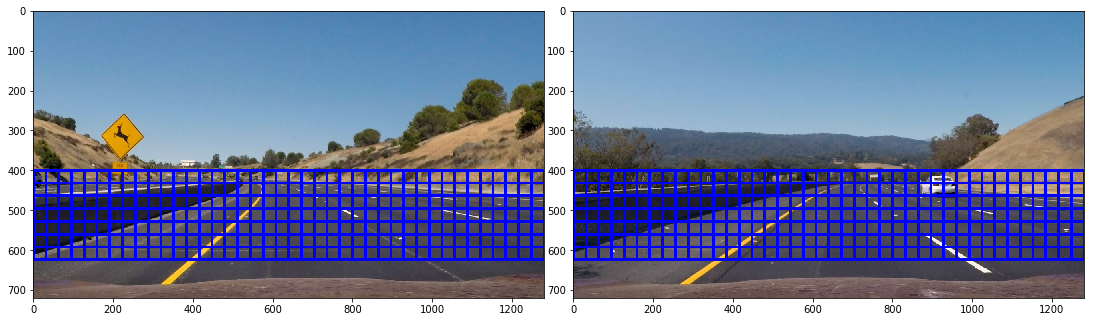

In [9]:
test_images = [mpimg.imread(image) for image in glob.glob("./test_images/*.jpg")]

bboxes_all = [slide_window(img, y_start_stop=[400, 650]) for img in test_images]
images_box = [draw_boxes(img, bboxes) for img, bboxes in zip(test_images, bboxes_all)]

display_images(images_box[:2], ncols=2, figsize=(15, 10))

The results of *prediction_single* are shown on the next set of images. Most of the cars were detected correctly (even cars which drive in the opposite direction). However there are some false positives and there is one false negative in the upper right image.

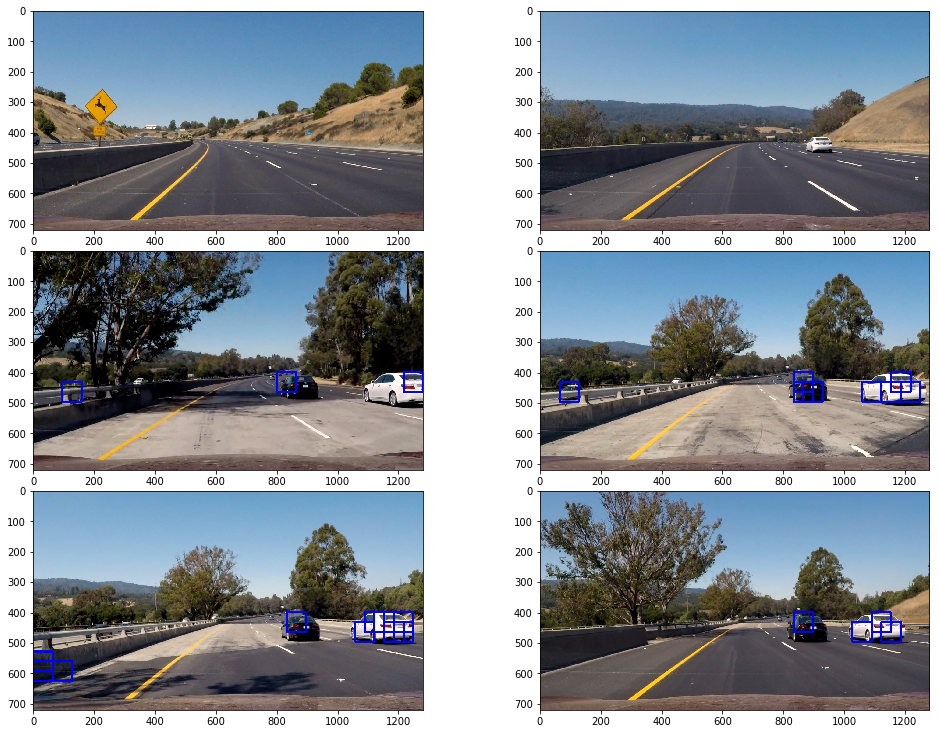

In [10]:
images_detect = []
for image, boxes in zip(test_images, bboxes_all):
    boxes_detect = prediction_single(image, boxes, X_scaler, svc)
    images_detect.append(draw_boxes(image, boxes_detect))

display_images(images_detect, ncols=2, figsize=(15, 10))

The function *predicition_single* used a fixed window size for generating the subimages. This is not an appropriate solution because of the varying distance between car and camera. The new function *prediction_multi* wraps *prediction_single* and calls it with varying window sizes (64x64, 70x70, 80x80, 90x90, 96x96, 112x112 and 128x128). The search space in y-direction is also slightly varied with varying window size.

The next set of images shows how *prediction_multi* performs on the test images. Each car is detected by multiple bounding boxes. However the false positive rate also increases.

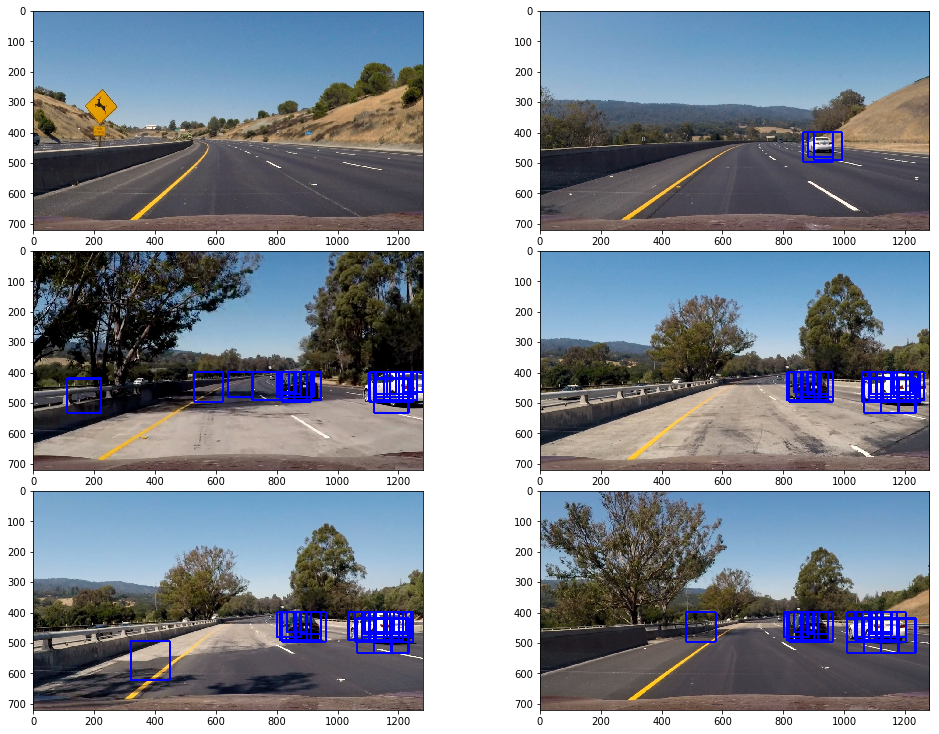

In [11]:
def prediction_multi(img, X_scaler, svc, conv='RGB2YUV', size=(32, 32), nbins=32, bins_range=(0, 256), 
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    """Applies windows of multiple sizes to detect cars.
        img            -- original image
        X_scaler       -- scaler to normalize the input data
        svc            -- classifier
        conv           -- color space trafo (None, RGB2YCrCb, RGB2LUV, RGB2HLS, RGB2HSV, RGB2YUV) 
        size           -- binning of spatial color feature
        nbins          -- binning of histogram
        bins_range     -- range of histogram
        orient         -- orientation
        pixel_per_cell -- pixels per cell
        cell_per_block -- cells per block
        hog_channel    -- hog channel (allowed values 0, 1, 2, ALL)       
    
    Returns:
       List of bounding boxes with a car.    
    """
    boxes_all = []    
    for start_stop, win_size in [([400, 480], 64), ([400, 480], 70), ([400, 500], 80), ([400, 500], 90), 
                                 ([400, 520], 96), ([420, 550], 112), ([430, 650], 128)]:
        boxes = slide_window(img, y_start_stop=start_stop, xy_window=(win_size, win_size))
        boxed_detect = prediction_single(img, boxes, X_scaler, svc, conv=conv, size=size, nbins=nbins, 
                                         bins_range=bins_range, orient=orient, pix_per_cell=pix_per_cell,
                                         cell_per_block=cell_per_block, hog_channel=hog_channel)
        boxes_all.append(boxed_detect)
    return flatten(boxes_all)
                   

def flatten(boxes):
    return [ele2 for ele1 in boxes for ele2 in ele1]



boxes_all = []
for img in test_images:
    boxes = prediction_multi(img, X_scaler, svc)
    boxes_all.append(boxes)
    
images_detect = []
for image, boxes in zip(test_images, boxes_all):
    boxes_detect = prediction_single(image, boxes, X_scaler, svc)
    images_detect.append(draw_boxes(image, boxes_detect))
    
    
display_images(images_detect, ncols=2, figsize=(15, 10))

We need a method to suppress these false positives otherwise the car might try to bypass other cars which are not present in real world. A heat map in combination with a threshold is an excellent way to achieve this. We increase the heat value of each pixel in case the pixel falls in the bounding box of a positive detection. If a pixel falls in multiple positive detection its value in the corresponding heat map is increased multiple times. 

On this ways the heat map intensities of cars - which are typically detected by multiple window sizes - are enhanced to the pixels of false positives - which have typically a heat map intensity of 1. A threshold allows to suppress these false positives entirely.

In [12]:
from scipy.ndimage.measurements import label

def add_heat(image, bbox_list):
    """Create heatmap of pixels.
    
    Args:
        image     -- original image
        bbox_list -- list of boxes i.e. detected cars
    """
    heatmap = np.zeros_like(image[:,:,0])
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap


def apply_threshold(heatmap, threshold):
    """Zero all pixels of heatmap with value below threshold."""
    heatmap[heatmap <= threshold] = 0
    return heatmap


def draw_labeled_bboxes(img, labels):
    """Draw boxes for detected cars.
    
    Args:
        img    -- original image
        labels -- output of labels function
    """
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

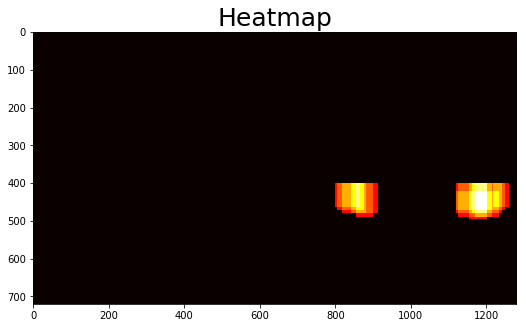

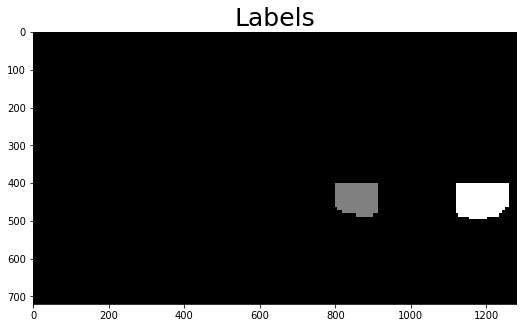

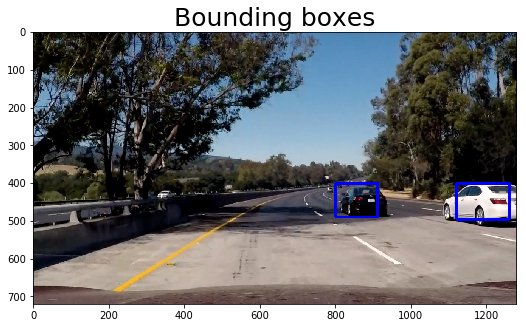

In [13]:
heatmap_img = add_heat(images_detect[2], boxes_all[2])
heatmap_img = apply_threshold(heatmap_img, 2)
labels = label(heatmap_img)
draw_img = draw_labeled_bboxes(np.copy(test_images[2]), labels)


plt.figure(figsize=(10,5))
plt.title("Heatmap", fontsize=25)
plt.imshow(heatmap_img, cmap='hot')
plt.figure(figsize=(10,5))
plt.title("Labels", fontsize=25)
plt.imshow(labels[0], cmap='gray')
plt.figure(figsize=(10,5))
plt.title("Bounding boxes", fontsize=25)
plt.imshow(draw_img);

We can further improve the false positive suppression by considering multiple frames of a video. A car is most likely detected in multiple video frames. We can combine the heat maps of a set of frames and set a higher threshold. This allows a cleaner separation between false positives and actual cars. The class *FindVehicles* considers the previous 11 frames to create the heat map of the current image. 

The results are shown in the next image. Each car is detected while all false positives are suppressed.

In [14]:
import collections

class FindVehicles:
    def __init__(self, X_scaler, svc):
        self.memory = 12
        self.boxes = collections.deque(maxlen=self.memory)
        self.X_scaler = X_scaler
        self.svc = svc

    def process_image(self, image, conv='RGB2YUV', size=(32, 32), nbins=32, bins_range=(0, 256), 
                      orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', thresh=10):
        """Process image with pipeline and return image with detected vehicles drawn on it.""" 
        boxes = prediction_multi(image, self.X_scaler, self.svc, conv=conv, size=size, nbins=nbins,
                                 bins_range=bins_range, orient=orient, pix_per_cell=pix_per_cell, 
                                 cell_per_block=cell_per_block, hog_channel=hog_channel)
        self.boxes.append(boxes)
        heatmap = add_heat(image, flatten(self.boxes))
        heatmap = apply_threshold(heatmap, thresh)
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        return draw_img
    

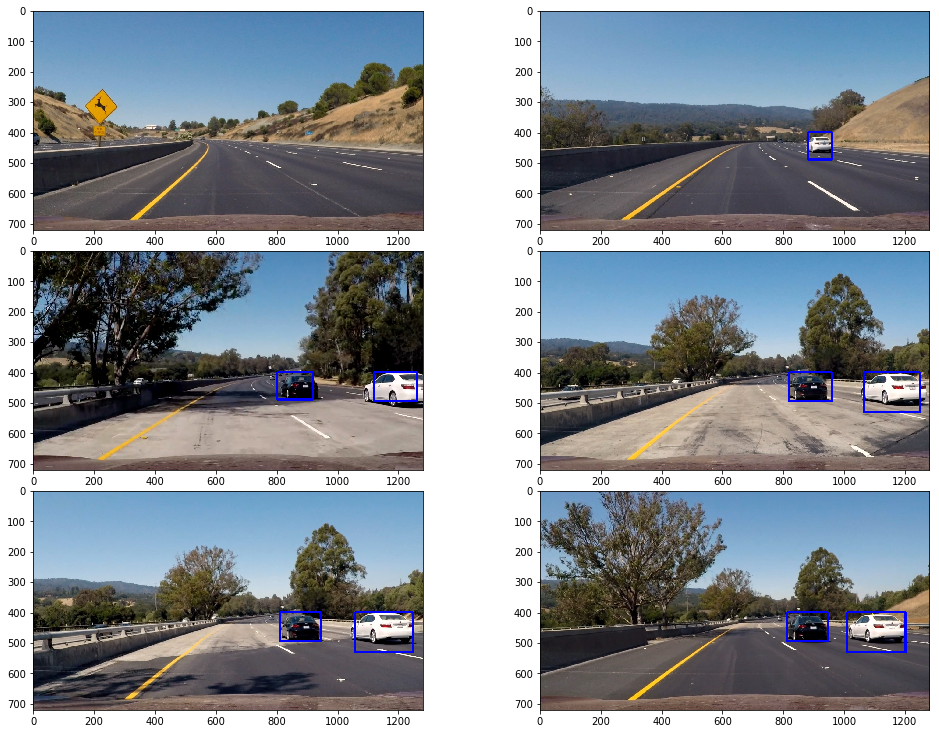

In [15]:
images_detect = []
for image in test_images:
    detector = FindVehicles(X_scaler, svc)
    images_detect.append(detector.process_image(image, thresh=1))

display_images(images_detect, ncols=2)

## 4. Process videos

Finally we test our algorithm on the video provided by Udacity (see link below). All cars are detected well and the quality is excellent for such a simple approach. Neverthless there remain some false positives and also the bounding boxes of the cars are not very stable.

In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

detector = FindVehicles(X_scaler, svc)

def process_video(video_input, video_output):
    clip = VideoFileClip(os.path.join('test_videos', video_input))
    processed = clip.fl_image(detector.process_image)
    processed.write_videofile(os.path.join('test_videos_output', video_output), audio=False)

In [57]:
%time process_video('project_video.mp4', 'project_video.mp4') 

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [18:27<00:00,  1.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 36min 8s, sys: 24.7 s, total: 36min 33s
Wall time: 18min 31s


* [project video](https://www.youtube.com/watch?v=zYyva7tc5KE)

## 5. Conclusions

We developed successfully an algorithm to detect cars a video stream employing a classifer, a sliding window technique and a method to suppress false positives. The algorithms works well although some false positive are still present. The stability of the bounding box has also to be improved. One possibilty is to improve the training set of the classifier to improve its accuracy and reduce its false positive predictions. The choosen window sizes can also be improved.